In [ ]:
!pip install git+https://github.com/airi-industrial-ai/ec23-tutorial -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 12.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import requests

from ectutorial.data import SlidingWindowDataset, get_ett_dataset
from ectutorial.gen_models import TCNGANModule
from ectutorial.plot import plot_pair_fake_val, plot_risk
from ectutorial.wcr import calculate_worst_case_risk

In [ ]:
ett = get_ett_dataset()
ett.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
val_thresh = int(ett.shape[0] * 0.7)
test_thresh = int(ett.shape[0] * 0.85)

train_data = ett.iloc[:val_thresh].copy()
val_data = ett.iloc[val_thresh:test_thresh].copy()
test_data = ett.iloc[test_thresh:].copy()

We apply a standard scaler for training stability.

In [ ]:
scaler = StandardScaler()
val_data_norm = scaler.fit_transform(val_data)

In [ ]:
window_size = 504
train_dataset = SlidingWindowDataset(val_data_norm, window_size=window_size, step_size=1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
len(train_loader)

32

In [ ]:
next(iter(train_loader))[0]

NameError: name 'train_loader' is not defined

In [ ]:
for batch in train_loader:
    break
batch.shape

torch.Size([64, 504, 7])

In [ ]:
gan = TCNGANModule(
    latent_dim=8,
    target_dim=len(ett.columns),
    hidden_dim=64,
    num_layers=4,
    lr=0.0001,
)

In [ ]:

trainer = Trainer(
    accelerator='auto',
    max_epochs=200,
    log_every_n_steps=10,
)

trainer.fit(
    model=gan,
    train_dataloaders=train_loader,
    val_dataloaders=train_loader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type      | Params
-----------------------------------
0 | gen  | TCNModule | 52.6 K
1 | disc | TCNModule | 51.2 K
-----------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


We load the pretrained model from a `checkpoint` file.

In [ ]:
# url = 'https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/models/ver=6-epoch=0-step=76.ckpt'
# r = requests.get(url)
# open('ver=6-epoch=0-step=76.ckpt', 'wb').write(r.content);

In [ ]:
# gan = TCNGANModule.load_from_checkpoint(
#     'ver=6-epoch=0-step=76.ckpt',
#     map_location='cpu',
#     latent_dim=8,
#     target_dim=len(ett.columns),
#     hidden_dim=64,
#     num_layers=4,
#     lr=0.0001,
# )

C:\Users\danil\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.3, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


Let us plot the pair plot to compare the fake and validation data. We can make fake data more "risky" by increasing the variance of the latent space using the temp parameter.

As our generator is a convolutional network, we can create a sequnce of an arbitrary length, for example 1000.

In [ ]:
torch.save(gan.state_dict(), 'gan_200')

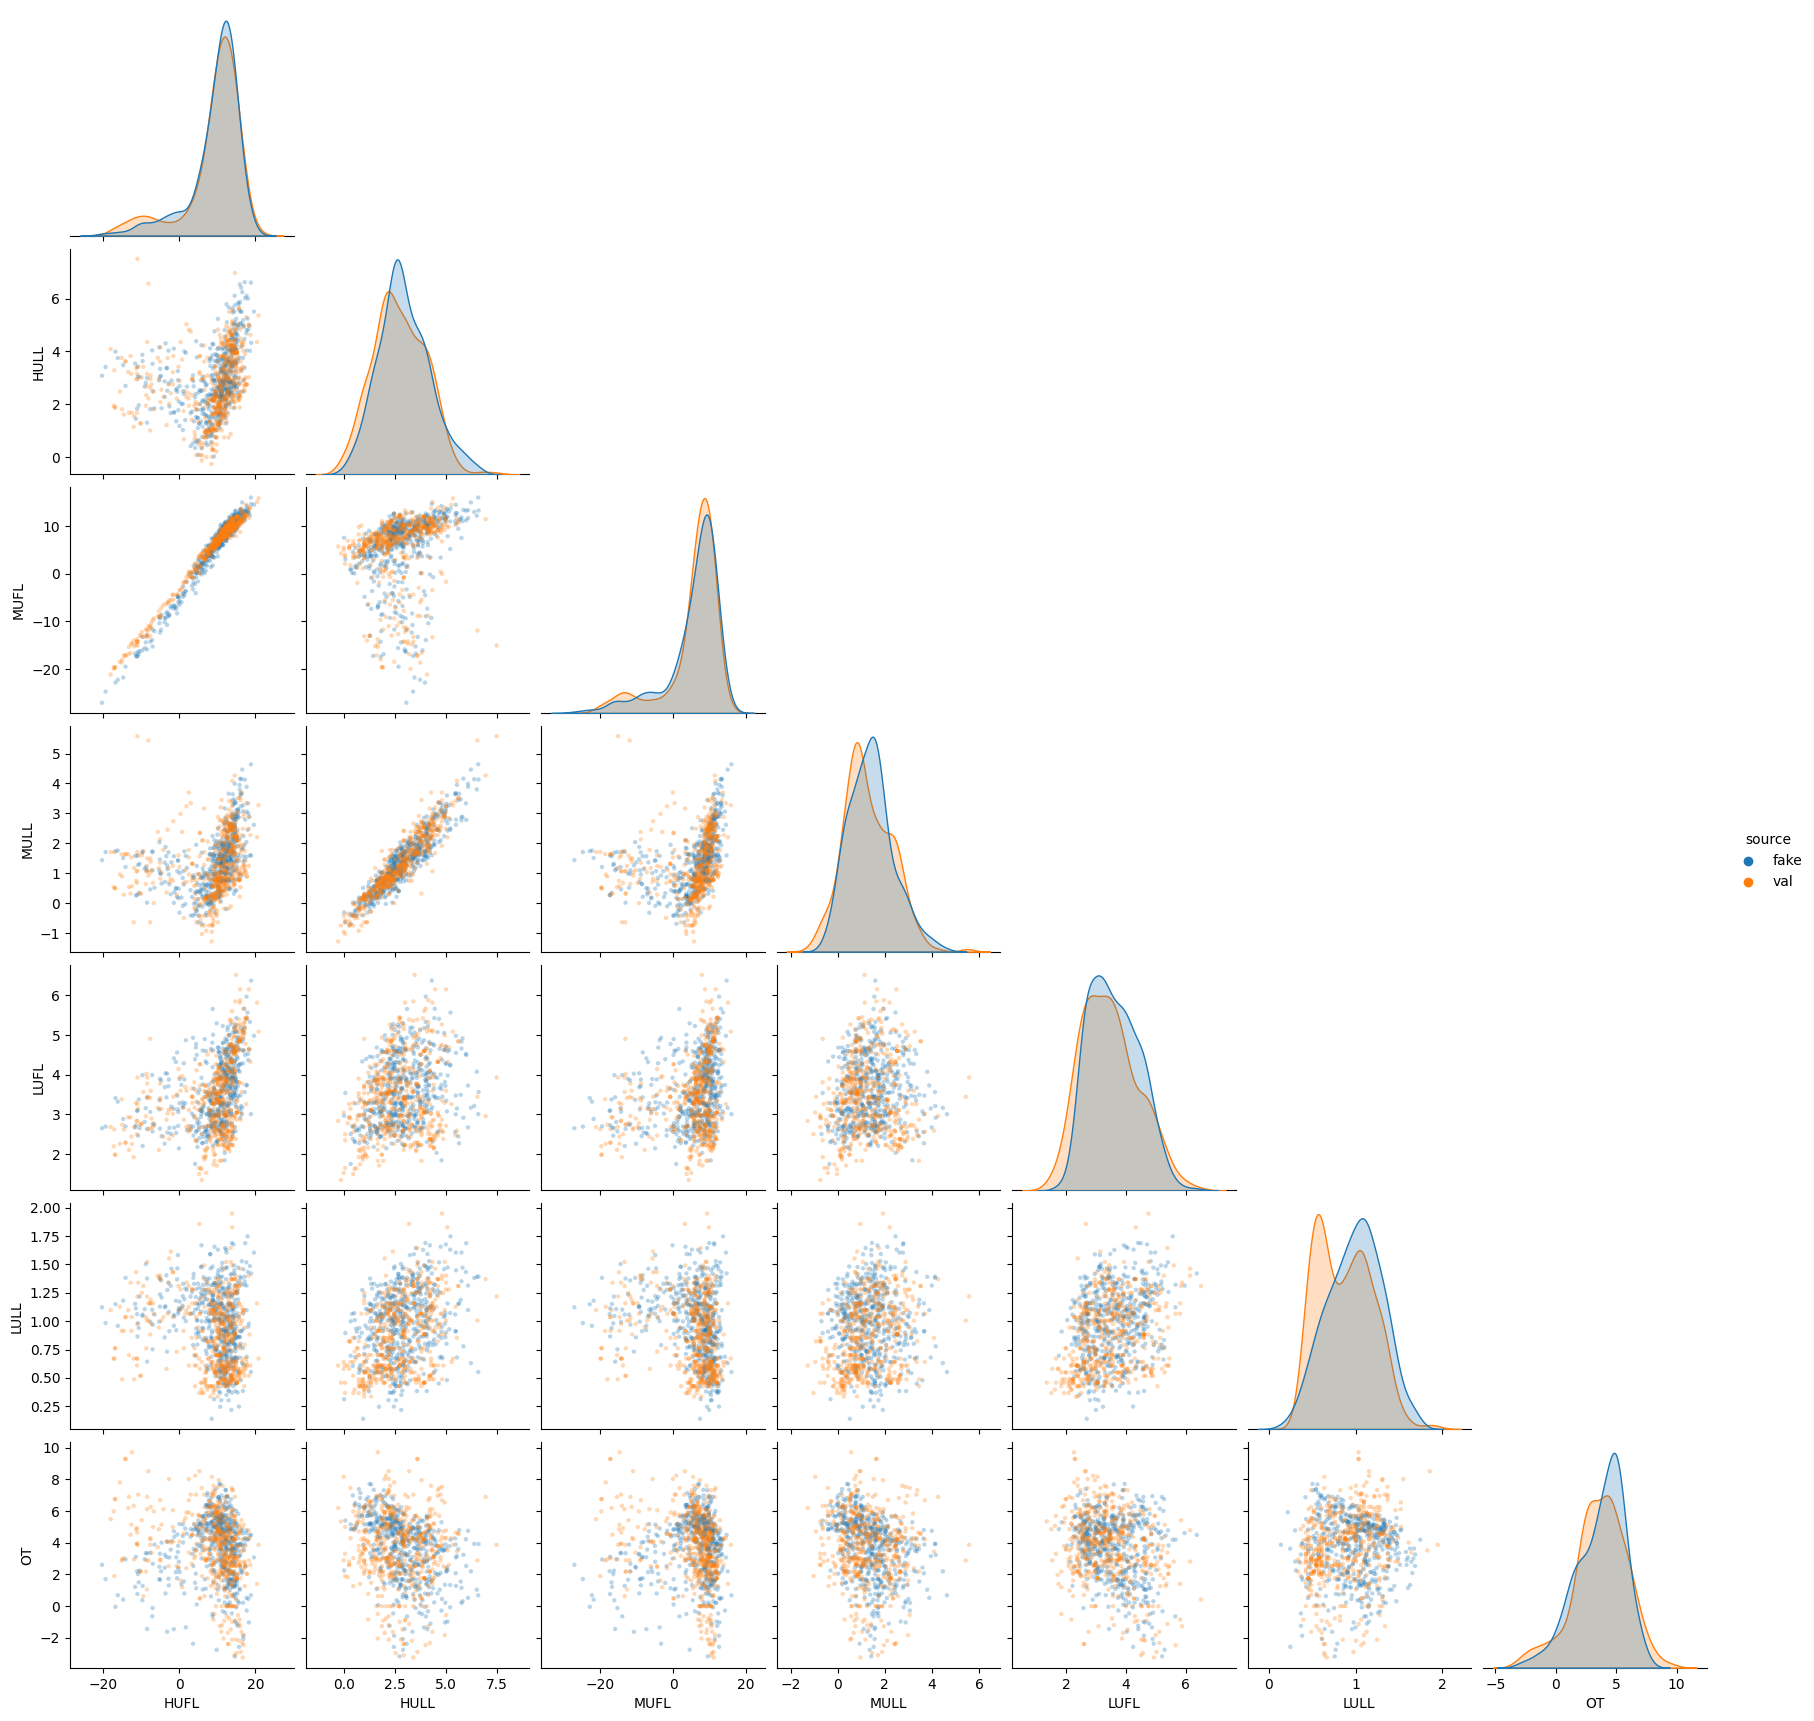

In [ ]:
seq_len = 504
torch.manual_seed(0)
fake = gan.sample(seq_len, temp=1)

plot_pair_fake_val(fake, val_data, scaler)

In [ ]:
fake.shape

torch.Size([1000, 7])

In [ ]:
from scipy.stats import ks_2samp

# scores = []
for (fake_feature, real_feature) in zip(range(7), val_data.columns):
    print(ks_2samp(scaler.inverse_transform(fake)[:, fake_feature], val_data.iloc[np.random.randint(len(val_data), size=seq_len)][real_feature].copy()))


KstestResult(statistic=0.06944444444444445, pvalue=0.1759392232129815, statistic_location=12.1899995803833, statistic_sign=-1)
KstestResult(statistic=0.16468253968253968, pvalue=2.206222899344731e-06, statistic_location=2.2769999504089355, statistic_sign=-1)
KstestResult(statistic=0.09126984126984126, pvalue=0.02998861906794667, statistic_location=8.670999526977539, statistic_sign=-1)
KstestResult(statistic=0.06547619047619048, pvalue=0.23027685518387683, statistic_location=0.9950000047683716, statistic_sign=-1)
KstestResult(statistic=0.13293650793650794, pvalue=0.0002662405173283922, statistic_location=2.559000015258789, statistic_sign=-1)
KstestResult(statistic=0.18055555555555555, pvalue=1.3590548296112625e-07, statistic_location=0.7609999775886536, statistic_sign=-1)
KstestResult(statistic=0.057539682539682536, pvalue=0.3747755803889234, statistic_location=1.7311481842792942, statistic_sign=1)


0.048628580807092536
0.038416981798175966
0.04965045271392282
0.03894902769515123
0.014637707873306167
0.00612341811525171
0.02567652094540343

all features mean:  0.03172609856404341


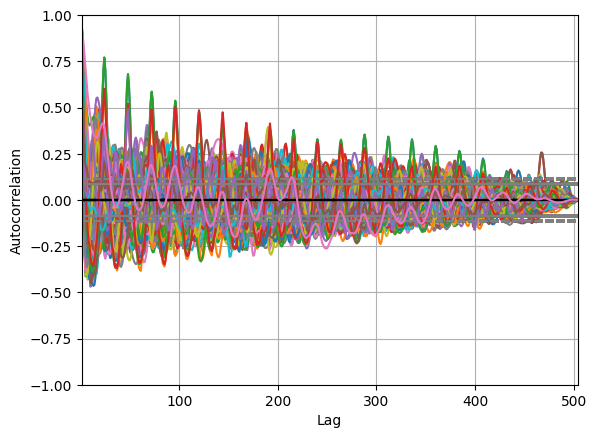

In [ ]:
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

n = 100
fake_autocorr = np.zeros_like(fake)

for _ in range(n):

    sampl = pd.DataFrame(scaler.inverse_transform(gan.sample(seq_len, temp=1)))
    feature_autocorr = []
    for i in range(len(val_data.columns)):

        feature_autocorr.append(autocorrelation_plot(sampl[i]).lines[-1].get_ydata())
        # first = first + pd.DataFrame(scaler.inverse_transform(vae.sample()))

    fake_autocorr = fake_autocorr + np.array(feature_autocorr).reshape(504, 7)

fake_autocorr_means = fake_autocorr / n


mses = []
for i, name in enumerate(val_data.columns):
    mses.append(mean_squared_error(autocorrelation_plot(val_data[name].iloc[:504]).lines[-1].get_ydata(), fake_autocorr_means[:, i]))
    print(mses[i])

print()
print('all features mean: ', np.mean(mses))

In [ ]:
corr_ett = val_data.corr() ######### тут весь вал
corr_ett.style.background_gradient(cmap='coolwarm')

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
HUFL,1.000000,0.176869,0.991993,0.176848,0.352024,-0.151119,-0.293206
HULL,0.176869,1.000000,0.151598,0.947016,0.233794,0.460964,-0.059751
MUFL,0.991993,0.151598,1.000000,0.168624,0.237596,-0.203998,-0.272968
MULL,0.176848,0.947016,0.168624,1.000000,0.110177,0.308971,-0.088006
LUFL,0.352024,0.233794,0.237596,0.110177,1.000000,0.367325,-0.227871
LULL,-0.151119,0.460964,-0.203998,0.308971,0.367325,1.000000,0.250384
OT,-0.293206,-0.059751,-0.272968,-0.088006,-0.227871,0.250384,1.000000


In [ ]:
n = 100

first = pd.DataFrame(scaler.inverse_transform(gan.sample(seq_len, temp=1))).corr()
for _ in range(n-1):
    first = first + pd.DataFrame(scaler.inverse_transform(gan.sample(seq_len, temp=1))).corr()
corr_ett_fake = first/ n
corr_ett_fake.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6
0,1.000000,0.403364,0.979779,0.481817,0.444637,-0.185979,-0.031490
1,0.403364,1.000000,0.380225,0.929981,0.308605,0.279865,-0.356962
2,0.979779,0.380225,1.000000,0.494194,0.350017,-0.231072,0.045642
3,0.481817,0.929981,0.494194,1.000000,0.153050,-0.011776,-0.329153
4,0.444637,0.308605,0.350017,0.153050,1.000000,0.259044,-0.310044
5,-0.185979,0.279865,-0.231072,-0.011776,0.259044,1.000000,0.063678
6,-0.031490,-0.356962,0.045642,-0.329153,-0.310044,0.063678,1.000000


In [ ]:
mean_squared_error(corr_ett_fake, corr_ett)

0.03424967726954486

In [ ]:
from tqdm import tqdm

generated_val = []
for i in tqdm(range((len(val_data) - 120) * 2)):
    generated_val.append(scaler.inverse_transform(gan.sample()))

In [ ]:
np.save('gan_generated.npy', generated_val)